This notebook collects open data of real estate trading records. (Dept of Land Administration M. O. I.) The work also includes the initial preprocessing.


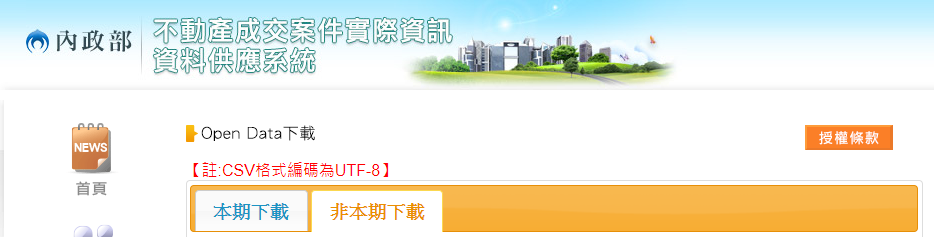
**Data Source:** https://plvr.land.moi.gov.tw/DownloadOpenData

In [1]:
# required packages
import io
import os
import sys

import pandas as pd
import numpy as np
import re
import math


import matplotlib.pyplot as plt

# google translation
# !pip install googletrans
from googletrans import Translator
# !pip install word2number
# convert word number to integer number
from word2number import w2n

## Import Data
We have 5,911 records and 28 columns.

In [2]:
path = r"..\artifacts\data"
df = pd.read_csv(path + "\A_lvr_land_A.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   鄉鎮市區          5911 non-null   object
 1   交易標的          5911 non-null   object
 2   土地區段位置建物區段門牌  5911 non-null   object
 3   土地移轉總面積平方公尺   5911 non-null   object
 4   都市土地使用分區      5877 non-null   object
 5   非都市土地使用分區     2 non-null      object
 6   非都市土地使用編定     1 non-null      object
 7   交易年月日         5911 non-null   object
 8   交易筆棟數         5911 non-null   object
 9   移轉層次          5284 non-null   object
 10  總樓層數          5272 non-null   object
 11  建物型態          5911 non-null   object
 12  主要用途          5107 non-null   object
 13  主要建材          5284 non-null   object
 14  建築完成年月        4674 non-null   object
 15  建物移轉總面積平方公尺   5911 non-null   object
 16  建物現況格局-房      5911 non-null   object
 17  建物現況格局-廳      5911 non-null   object
 18  建物現況格局-衛      5911 non-null   object
 19  建物現況格局

鄉鎮市區              交易標的  \
0  The villages and towns urban district  transaction sign   
1                                    中正區                土地   
2                                    文山區         房地(土地+建物)   

                                        土地區段位置建物區段門牌  \
0  land sector position building sector house num...   
1                                    河堤段六小段481~510地號   
2                                臺北市文山區木新路三段211~240號   

                             土地移轉總面積平方公尺  \
0  land shifting total area square meter   
1                                    4.0   
2                                  40.75   

                                都市土地使用分區  \
0  the use zoning or compiles and checks   
1                                      商   
2                                      住   

                              非都市土地使用分區                非都市土地使用編定  \
0  the non-metropolis land use district  non-metropolis land use   
1                                   NaN                      NaN   
2                                   NaN                      NaN   

                            交易年月日                   交易筆棟數            移轉層次  \
0  transaction year month and day  transaction pen number  shifting level   
1                         1081021               土地1建物0車位0             NaN   
2                         1081007               土地1建物1車位0           三層，陽台   

   ...                                     建物現況格局-衛  \
0  ...  building present situation pattern - health   
1  ...                                            0   
2  ...                                            4   

                                           建物現況格局-隔間  \
0  building present situation pattern - compartme...   
1                                                  有   
2                                                  有   

                                      有無管理組織              總價元  \
0  Whether there is manages the organization  total price NTD   
1                                          無          1600000   
2                                          無         11850000   

                               單價元平方公尺                車位類別  \
0  the unit price (NTD / square meter)  the berth category   
1                               400000                 NaN   
2                               108358                 NaN   

                              車位移轉總面積平方公尺                      車位總價元  \
0  berth shifting total area square meter  the berth total price NTD   
1                                     0.0                          0   
2                                     0.0                          0   

            備註                   編號  
0     the note        serial number  
1          NaN  RPOOMLLKJIOFFAA96CA  
2  含增建或未登記建物。;  RPWOMLMKJIOFFAA87CA  

[3 rows x 28 columns]

## Preprocess Data

In [3]:
df = df.drop(0, axis=0) # drop the first row which is English name of columns
# rename columns
COL_NAME = ['district', 'transaction_type', 'address', 'land_shift_area', 'urban_land_use', 'non_urban_use', 'non_urban_use_code',
           'transaction_date', 'transaction_number', 'shift_level', 'total_levels', 'building_state', 'main_use',
           'main_building_material', 'complete_year', 'building_shift_total_area', 'num_room', 'num_hall', 'num_toilet', 'num_partition',
           'management_org', 'total_ntd', 'unit_ntd', 'carpark_category', 'carpark_shift_area', 'carpark_ntd', 'note', 'serial_no']
df.columns = COL_NAME
df.head(1)

district transaction_type          address land_shift_area urban_land_use  \
1      中正區               土地  河堤段六小段481~510地號             4.0              商   

  non_urban_use non_urban_use_code transaction_date transaction_number  \
1           NaN                NaN          1081021          土地1建物0車位0   

  shift_level  ... num_toilet num_partition management_org total_ntd unit_ntd  \
1         NaN  ...          0             有              無   1600000   400000   

  carpark_category carpark_shift_area carpark_ntd note            serial_no  
1              NaN                0.0           0  NaN  RPOOMLLKJIOFFAA96CA  

[1 rows x 28 columns]

In [4]:
# df.to_csv(r'..\artifacts\data\taipei_city_real_estate_transaction.csv', index=False)

## Simplify the Dataset
### We drop some of non-applicable columns.
* non_urban_use and non_urban_use_code have 99.9% and 100% of missing values so drop them out.
* note and serial_no: content cannot be directly used

In [5]:
# # check unique values in each column
# for col in df.columns:
#     unique_values = pd.unique(df[col])
#     print(col, unique_values)

# # check missing values
# df.isnull().sum()/len(df)

In [6]:
DROPED_COLUMNS = ['non_urban_use', 'non_urban_use_code', 'note', 'serial_no']
df = df.drop(DROPED_COLUMNS,axis=1)
df.head()

district transaction_type                address land_shift_area  \
1      中正區               土地        河堤段六小段481~510地號             4.0   
2      文山區        房地(土地+建物)    臺北市文山區木新路三段211~240號           40.75   
3      文山區        房地(土地+建物)  臺北市文山區福興路78巷20弄31~60號           33.81   
4      文山區     房地(土地+建物)+車位    臺北市文山區忠順街一段10巷1~30號           32.19   
5      文山區        房地(土地+建物)      臺北市文山區萬壽路25巷1~30號           60.25   

  urban_land_use transaction_date transaction_number shift_level total_levels  \
1              商          1081021          土地1建物0車位0         NaN          NaN   
2              住          1081007          土地1建物1車位0       三層，陽台           四層   
3              住          1081006          土地2建物1車位0          三層           五層   
4              住          1080428          土地1建物1車位1          三層          十一層   
5              住          1081023          土地1建物1車位0          一層           十層   

    building_state  ... num_room num_hall num_toilet num_partition  \
1               其他  ...        0        0          0             有   
2     公寓(5樓含以下無電梯)  ...        4        0          4             有   
3     公寓(5樓含以下無電梯)  ...        3        2          2             有   
4  住宅大樓(11層含以上有電梯)  ...        3        2          2             有   
5    華廈(10層含以下有電梯)  ...        3        2          3             有   

  management_org total_ntd unit_ntd carpark_category carpark_shift_area  \
1              無   1600000   400000              NaN                0.0   
2              無  11850000   108358              NaN                0.0   
3              無  10000000    91391              NaN                0.0   
4              有  21000000   128417             坡道平面                0.0   
5              有  67203400   328158              NaN                0.0   

  carpark_ntd  
1           0  
2           0  
3           0  
4           0  
5           0  

[5 rows x 24 columns]

### Transform Data Types

In [7]:
df['land_shift_area'] = df['land_shift_area'].astype(float)
df['building_shift_total_area'] = df['building_shift_total_area'].astype(float)
df['total_ntd'] = df['total_ntd'].astype(float)

### Deal with Missing Values

In [8]:
df['urban_land_use'] = df['urban_land_use'].fillna('Others')
df['shift_level'] = df['shift_level'].fillna(0) # land and car park transaction have no shifting levels 
df['total_levels'] = df['total_levels'].fillna(0) # land and car park transaction have no shifting levels 
df['main_use'] = df['main_use'].fillna('見其他登記事項') # replace nan values with others
df['main_building_material'] = df['main_building_material'].fillna('Not Applicable') # land and car park transaction have no building material
df['carpark_category'] = df['carpark_category'].fillna('Not Applicable') # land and building transaction have no carpark category

def calculate_unit_price(x):
    """
    calculate unit price based on the transaction type
    """
    # for land/car park transaction, building_shift_total_area is not equal to 0
    if x['building_shift_total_area'] != 0:
        return x['total_ntd']/x['building_shift_total_area']
    # for land/car park transaction, building_shift_total_area is equal to 0, so calculate the unit price based on land shift area
    else:
        return x['total_ntd']/x['land_shift_area']

df['unit_ntd'] = df.apply(calculate_unit_price, axis=1)

In [9]:
# step 1: convert nan values to 0, extract year from date
def extract_year_info(x):
    # type of nan is str
    if type(x) != str:
        return x
    elif x[0] == '0':
        return int(x[1:3]) # for year values like 068
    else:
        return int(x[0:3]) # for year values like 108
df['complete_year'] = df['complete_year'].apply(extract_year_info)

# step 2: change nan based on grouping result
"""
for land or car park, there might be no definition for complete year,
which means if all the values in a group are nan, then assign value 0.
else, check if there is any missing values, and assign missing values with a mean value.
"""
GROUPBY_COL = ['district', 'urban_land_use', 'total_levels', 'management_org', 'building_state']
df['complete_year'] = df.groupby(GROUPBY_COL)['complete_year'].transform(lambda s: [0 if math.isnan(x) and math.isnan(s.mean())
                                                                                    else (s.mean() if math.isnan(x) else x)
                                                                                    for x in s])

### Check the Missing Values

In [10]:
df.isnull().sum()

district                     0
transaction_type             0
address                      0
land_shift_area              0
urban_land_use               0
transaction_date             0
transaction_number           0
shift_level                  0
total_levels                 0
building_state               0
main_use                     0
main_building_material       0
complete_year                0
building_shift_total_area    0
num_room                     0
num_hall                     0
num_toilet                   0
num_partition                0
management_org               0
total_ntd                    0
unit_ntd                     0
carpark_category             0
carpark_shift_area           0
carpark_ntd                  0
dtype: int64

### Extract Information and Features

* transaction_date: parse year, month, weekday
* building_age
* transaction_number: parse the number of land, building, parking space
* shift_level:parse the number of levels
* total_levels: parse number of total levels

In [11]:
# extract trasaction year and month and building age
df['transaction_year'] = df['transaction_date'].apply(lambda x: str(1911 + int(x[:-4]))) # year should be categorical value
df['transaction_month'] = df['transaction_date'].apply(lambda x: x[-4:-2])
df['building_age'] = df['transaction_year'].astype(int) - df['complete_year']

# extract number of land, building and carpark out of transaction number column
df['number_of_land'] = df['transaction_number'].apply(lambda x: int(re.findall('土地\d+', x)[0][2:]))
df['number_of_building'] = df['transaction_number'].apply(lambda x: int(re.findall('建物\d+', x)[0][2:]))
df['number_of_carpark'] = df['transaction_number'].apply(lambda x: int(re.findall('車位\d+', x)[0][2:]))

df.head()

district transaction_type                address  land_shift_area  \
1      中正區               土地        河堤段六小段481~510地號             4.00   
2      文山區        房地(土地+建物)    臺北市文山區木新路三段211~240號            40.75   
3      文山區        房地(土地+建物)  臺北市文山區福興路78巷20弄31~60號            33.81   
4      文山區     房地(土地+建物)+車位    臺北市文山區忠順街一段10巷1~30號            32.19   
5      文山區        房地(土地+建物)      臺北市文山區萬壽路25巷1~30號            60.25   

  urban_land_use transaction_date transaction_number shift_level total_levels  \
1              商          1081021          土地1建物0車位0           0            0   
2              住          1081007          土地1建物1車位0       三層，陽台           四層   
3              住          1081006          土地2建物1車位0          三層           五層   
4              住          1080428          土地1建物1車位1          三層          十一層   
5              住          1081023          土地1建物1車位0          一層           十層   

    building_state  ...       unit_ntd carpark_category  carpark_shift_area  \
1               其他  ...  400000.000000   Not Applicable                 0.0   
2     公寓(5樓含以下無電梯)  ...  108357.717630   Not Applicable                 0.0   
3     公寓(5樓含以下無電梯)  ...   91390.970572   Not Applicable                 0.0   
4  住宅大樓(11層含以上有電梯)  ...  128416.804256             坡道平面                 0.0   
5    華廈(10層含以下有電梯)  ...  328157.624884   Not Applicable                 0.0   

   carpark_ntd transaction_year transaction_month building_age number_of_land  \
1            0             2019                10    2019.0000              1   
2            0             2019                10    1956.9375              1   
3            0             2019                10    1950.0000              2   
4            0             2019                04    1935.0000              1   
5            0             2019                10    1911.0000              1   

  number_of_building  number_of_carpark  
1                  0                  0  
2                  1                  0  
3                  1                  0  
4                  1                  1  
5                  1                  0  

[5 rows x 30 columns]

In [12]:
# too unstructured to extract info
pd.unique(df['shift_level']), pd.unique(df['total_levels']) 

(array([0, '三層，陽台', '三層', '一層', '十層', '五層', '四層，露台', '四層', '六層', '九層',
        '七層', '八層', '十三層', '二層', '十四層', '地下五層', '全', '一層，騎樓', '十六層',
        '地下二層', '十二層', '十五層', '十一層', '地下一層', '四層，陽台', '二十層', '二層，陽台',
        '三層，四層', '地下二層，地下三層，地下四層', '三層，二層', '一層，地下一層', '地下層', '一層，平台',
        '七層，陽台', '一層，三層，四層，五層，六層，陽台，屋頂突出物，地下層', '三層，電梯樓梯間', '地下層，一層，二層',
        '地下三層', '五層，電梯樓梯間', '十七層', '二十七層', '一層，二層', '一層，地下層', '地下二層，地下三層',
        '二十四層', '九層，見其他登記事項', '地下一層，地下二層', '一層，騎樓，停車場', '七層，電梯樓梯間', '二十五層',
        '二十二層', '騎樓，停車場，一層', '九層，十層', '十四層，陽台', '十層，露台', '四層，五層', '十九層',
        '十四層，電梯樓梯間', '一層，電梯樓梯間', '五層，陽台', '六層，陽台', '十三層，十二層', '六層，電梯樓梯間',
        '陽台，三層', '二層，電梯樓梯間', '三層，騎樓', '一層，二層，騎樓', '地下三層，地下四層', '四層，五層，夾層',
        '地下層，見使用執照', '四層，電梯樓梯間', '防空避難室', '十八層', '一層，平台，騎樓', '電梯樓梯間，四層',
        '一層，地下一層，地下三層，地下二層', '十層，電梯樓梯間', '騎樓，一層', '六層，七層', '二層，三層',
        '八層，九層', '地下一層，地下二層，地下三層', '十一層，露台', '地下四層', '九層，陽台，電梯樓梯間',
        '六層，陽台，見其他登記事項', '一層，地下四層', '十二層，夾層', '三層，露台', '地下三層，地下四

In [13]:
# drop unnecessary columns
DROPED_COLUMNS = ['address', 'transaction_date', 'transaction_number', 'shift_level', 'total_levels', 'building_state']
df.drop(DROPED_COLUMNS, axis=1, inplace=True)
df.head()

district transaction_type  land_shift_area urban_land_use main_use  \
1      中正區               土地             4.00              商  見其他登記事項   
2      文山區        房地(土地+建物)            40.75              住  見其他登記事項   
3      文山區        房地(土地+建物)            33.81              住      住家用   
4      文山區     房地(土地+建物)+車位            32.19              住      住家用   
5      文山區        房地(土地+建物)            60.25              住  見其他登記事項   

  main_building_material  complete_year  building_shift_total_area num_room  \
1         Not Applicable         0.0000                       0.00        0   
2                 鋼筋混凝土造        62.0625                     109.36        4   
3                 鋼筋混凝土造        69.0000                     109.42        3   
4                 鋼筋混凝土造        84.0000                     163.53        3   
5                 鋼筋混凝土造       108.0000                     204.79        3   

  num_hall  ...       unit_ntd carpark_category carpark_shift_area  \
1        0  ...  400000.000000   Not Applicable                0.0   
2        0  ...  108357.717630   Not Applicable                0.0   
3        2  ...   91390.970572   Not Applicable                0.0   
4        2  ...  128416.804256             坡道平面                0.0   
5        2  ...  328157.624884   Not Applicable                0.0   

   carpark_ntd  transaction_year transaction_month building_age  \
1            0              2019                10    2019.0000   
2            0              2019                10    1956.9375   
3            0              2019                10    1950.0000   
4            0              2019                04    1935.0000   
5            0              2019                10    1911.0000   

  number_of_land number_of_building number_of_carpark  
1              1                  0                 0  
2              1                  1                 0  
3              2                  1                 0  
4              1                  1                 1  
5              1                  1                 0  

[5 rows x 24 columns]

### Translate Mandarian to English

Two methods to do translation but both have the limits of translation quota.
1. Google Translation <br>
translator = Translator()
translator.translate(x, dest='en').text
2. Translator <br>
from translate import Translator
translator= Translator(from_lang="zh-TW", to_lang="english")

In [16]:
# 0. fields to translate: transaction_type, urban_land_use, main_use, main_building_material,carpark_category
COL_TO_TRANSLATE = ['district', 'transaction_type', 'urban_land_use', 'main_use', 
                    'main_building_material', 'carpark_category']
# 1. find unique words and do translation
dic_translation = {}
from translate import Translator
translator= Translator(from_lang="zh-TW", to_lang="english")

for col in COL_TO_TRANSLATE:
    for word in pd.unique(df[col]).tolist():
        dic_translation[word] = translator.translate(word)

dic_translation

{'中正區': 'Zhongzheng District',
 '文山區': 'Wenshan District',
 '大同區': 'Datong District',
 '萬華區': 'Wanhua District',
 '內湖區': 'Neihu District',
 '中山區': 'Zhongshan Area',
 '信義區': 'Xinyi District',
 '松山區': 'Songshan District',
 '北投區': 'Beitou',
 '士林區': 'shihlin',
 '大安區': 'Daan District',
 '南港區': 'Nangang District'}

In [17]:
# 2. conduct replacement
for col in COL_TO_TRANSLATE:
    df[col] = df[col].map(dic_translation)
df.head()

district                            transaction_type  \
1  Zhongzheng District                                        Land   
2     Wenshan District                  Premises (land + building)   
3     Wenshan District                  Premises (land + building)   
4     Wenshan District  Premises (land + building) + parking space   
5     Wenshan District                  Premises (land + building)   

   land_shift_area urban_land_use                      main_use  \
1             4.00       Quotient  See other registration items   
2            40.75        Address  See other registration items   
3            33.81        Address                      Resident   
4            32.19        Address                      Resident   
5            60.25        Address  See other registration items   

             main_building_material  complete_year  building_shift_total_area  \
1                    Not Applicable         0.0000                       0.00   
2  Reinforced concrete construction        62.0625                     109.36   
3  Reinforced concrete construction        69.0000                     109.42   
4  Reinforced concrete construction        84.0000                     163.53   
5  Reinforced concrete construction       108.0000                     204.79   

  num_room num_hall  ...       unit_ntd carpark_category carpark_shift_area  \
1        0        0  ...  400000.000000   Not Applicable                0.0   
2        4        0  ...  108357.717630   Not Applicable                0.0   
3        3        2  ...   91390.970572   Not Applicable                0.0   
4        3        2  ...  128416.804256       Ramp plane                0.0   
5        3        2  ...  328157.624884   Not Applicable                0.0   

   carpark_ntd  transaction_year transaction_month building_age  \
1            0              2019                10    2019.0000   
2            0              2019                10    1956.9375   
3            0              2019                10    1950.0000   
4            0              2019                04    1935.0000   
5            0              2019                10    1911.0000   

  number_of_land number_of_building number_of_carpark  
1              1                  0                 0  
2              1                  1                 0  
3              2                  1                 0  
4              1                  1                 1  
5              1                  1                 0  

[5 rows x 24 columns]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 1 to 5910
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   district                   5910 non-null   object 
 1   transaction_type           5910 non-null   object 
 2   land_shift_area            5910 non-null   float64
 3   urban_land_use             5910 non-null   object 
 4   main_use                   5910 non-null   object 
 5   main_building_material     5910 non-null   object 
 6   complete_year              5910 non-null   float64
 7   building_shift_total_area  5910 non-null   float64
 8   num_room                   5910 non-null   object 
 9   num_hall                   5910 non-null   object 
 10  num_toilet                 5910 non-null   object 
 11  num_partition              5910 non-null   object 
 12  management_org             5910 non-null   object 
 13  total_ntd                  5910 non-null   float

In [22]:
# df.to_csv(r'..\artifacts\data\taipei_city_real_estate_transaction.csv', index=False)

In [23]:
df = pd.read_csv(r'..\artifacts\data\taipei_city_real_estate_transaction.csv')
df.describe()

land_shift_area  complete_year  building_shift_total_area     num_room  \
count      5910.000000    5910.000000                5910.000000  5910.000000   
mean         54.811547      72.655683                 119.489932     2.074450   
std         343.706459      32.027520                 177.267121     1.600011   
min           0.000000       0.000000                   0.000000     0.000000   
25%          10.000000      65.000000                  49.555000     1.000000   
50%          21.875000      76.000000                  96.160000     2.000000   
75%          35.000000      97.000000                 144.985000     3.000000   
max       14005.600000     108.000000                6191.160000    24.000000   

          num_hall   num_toilet     total_ntd      unit_ntd  \
count  5910.000000  5910.000000  5.910000e+03  5.910000e+03   
mean      1.318782     1.300508  2.570146e+07  1.919043e+05   
std       0.885319     1.045933  6.936728e+07  3.681883e+05   
min       0.000000     0.000000  0.000000e+00  0.000000e+00   
25%       1.000000     1.000000  8.700000e+06  1.251562e+05   
50%       2.000000     1.000000  1.600000e+07  1.667010e+05   
75%       2.000000     2.000000  2.700000e+07  2.171814e+05   
max       9.000000    23.000000  4.020487e+09  2.555556e+07   

       carpark_shift_area   carpark_ntd  transaction_year  transaction_month  \
count         5910.000000  5.910000e+03       5910.000000        5910.000000   
mean            10.334766  5.755643e+05       2018.997293          10.120643   
std             25.169795  1.592218e+06          0.626319           2.541814   
min              0.000000  0.000000e+00       1986.000000           1.000000   
25%              0.000000  0.000000e+00       2019.000000          10.000000   
50%              0.000000  0.000000e+00       2019.000000          11.000000   
75%              0.000000  0.000000e+00       2019.000000          12.000000   
max            617.500000  2.670000e+07       2020.000000          12.000000   

       building_age  number_of_land  number_of_building  number_of_carpark  
count   5910.000000     5910.000000         5910.000000        5910.000000  
mean    1946.341610        1.453976            0.913367           0.453299  
std       32.072617        1.365073            0.633531           0.982553  
min     1907.000000        0.000000            0.000000           0.000000  
25%     1922.000000        1.000000            1.000000           0.000000  
50%     1943.000000        1.000000            1.000000           0.000000  
75%     1954.000000        2.000000            1.000000           1.000000  
max     2020.000000       24.000000           25.000000          33.000000